In [1]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset
from torchvision import transforms,utils
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
import cv2
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight

In [3]:
import kagglehub

path = kagglehub.dataset_download("mariaherrerot/aptos2019")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/aptos2019


In [4]:
list_dir = os.listdir(path)
print(list_dir)

['val_images', 'train_images', 'valid.csv', 'test.csv', 'train_1.csv', 'test_images']


In [5]:
train_images=path+'/train_images'*2
train_labels=pd.read_csv(path+'/train_1.csv')
valid_images=path+'/val_images'*2
valid_labels=pd.read_csv(path+'/valid.csv')
test_images=path+'/test_images'*2
test_labels=pd.read_csv(path+'/test.csv')

In [6]:
train_labels.head()

,id_code,diagnosis
0,1ae8c165fd53,2
1,1b329a127307,1
2,1b32e1d775ea,4
3,1b3647865779,0
4,1b398c0494d1,0


<Axes: xlabel='diagnosis', ylabel='count'>

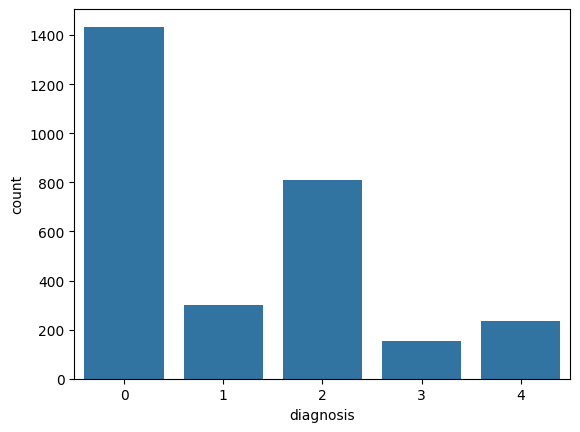

In [7]:
sns.countplot(train_labels,x='diagnosis')

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.array([0,1,2,3,4]),y=train_labels['diagnosis'].values)
class_weights = torch.tensor(class_weights,dtype=torch.float).to(device)
print(class_weights)

tensor([0.4086, 1.9533, 0.7252, 3.8052, 2.5043])


In [10]:
images=os.listdir(test_images)
all_png = all(img.endswith('.png') for img in images)

print("All images are PNG:", all_png)

All images are PNG: True


In [11]:
class DDRDataset(Dataset):
    def __init__(self,images_path,labels, transform=None,mode='rgb_clahe'):
       self.images_path=images_path
       self.labels=labels
       self.transform=transform
       self.mode=mode

    def apply_clahe_rgb(self, image):
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        merged = cv2.merge((cl, a, b))
        return  merged

    def apply_green_clahe(self,image):
      green = image[:, :, 1]
      clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
      green_enhanced = clahe.apply(green)
      return cv2.merge([green_enhanced]*3)

    def apply_circular_mask(self,image):
      h, w = image.shape[:2]
      center = (w // 2, h // 2)
      radius = min(center[0], center[1])

      Y, X = np.ogrid[:h, :w]
      dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
      mask = dist_from_center <= radius

      if image.ndim == 3:
          mask = np.stack([mask] * 3, axis=-1)

      masked_image = image.copy()
      masked_image[~mask] = 0
      return masked_image

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image_name=self.labels.iloc[index,0]+'.png'
        image_path=os.path.join(self.images_path,image_name)
        image=cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at path: {image_path}")
        label=int(self.labels.iloc[index,1])
        label=torch.tensor(label).long()
        if self.mode=='rgb_clahe':
            image=self.apply_clahe_rgb(image)
            image=cv2.cvtColor(image, cv2.COLOR_LAB2RGB)
        elif self.mode=="lab_clahe":
          image=self.apply_clahe_rgb(image)

        elif self.mode=="green_clahe":
          image=self.apply_green_clahe(image)
        else:
          image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        #image=self.apply_circular_mask(image)
        if self.transform:
            image=self.transform(image)
        else:
            image=transforms.ToTensor()(image)
        return image,label


In [12]:
transforms_train=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=[-180, 180],
                                fill=0,interpolation=transforms.InterpolationMode.BICUBIC),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.2)
])
transforms_test=transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224),interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [13]:
train_dataset=DDRDataset(train_images,train_labels,transform=transforms_train)
valid_dataset=DDRDataset(valid_images,valid_labels,transform=transforms_test)
test_dataset=DDRDataset(test_images,test_labels,transform=transforms_test)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
valid_loader=torch.utils.data.DataLoader(valid_dataset,batch_size=16,shuffle=False)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=16,shuffle=False)

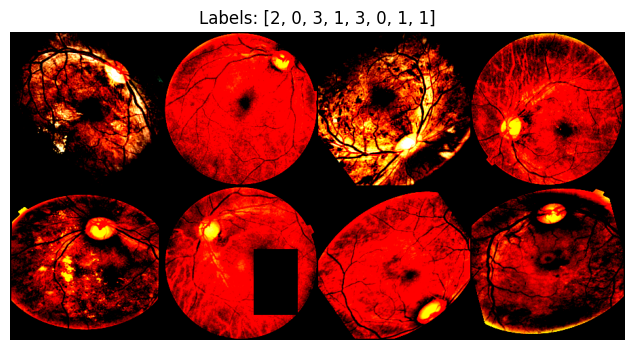

In [14]:
for images, labels in train_loader:
    grid_img =utils.make_grid(images[:8], nrow=4, padding=2)
    np_img = grid_img.permute(1, 2, 0).cpu().numpy()
    np_img = np_img.clip(0, 1)

    plt.figure(figsize=(10, 4))
    plt.imshow(np_img)
    plt.title(f"Labels: {labels[:8].tolist()}")
    plt.axis('off')
    plt.show()
    break

In [15]:
num_classes=5
model=models.mobilenet_v2(pretrained=True)
print(model)
model.classifier[1]=nn.Linear(model.last_channel,num_classes)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 33.0MB/s]

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [16]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=10, checkpoint_path="mobilenet_dr.pth"):
    best_val_loss = float('inf')
    l_val_loss=[]
    l_train_loss=[]
    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")


        model.train()
        train_loss = 0.0
        train_correct = 0
        total = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            train_correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / total
        train_acc = train_correct / total
        print(f"Train Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.4f}")
        l_train_loss.append(avg_train_loss)


        model.eval()
        val_loss = 0.0
        val_correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(valid_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, dim=1)
                val_correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / total
        val_acc = val_correct / total
        print(f"Val Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")
        l_val_loss.append(avg_val_loss)


        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Saved checkpoint at epoch {epoch+1}")
    return l_train_loss,l_val_loss

In [17]:
def test_model(model, test_loader, criterion, device, num_classes=5):
    model.eval()

    accuracy = Accuracy(task="multiclass", num_classes=num_classes).to(device)
    precision = Precision(task="multiclass", num_classes=num_classes, average='weighted').to(device)
    recall = Recall(task="multiclass", num_classes=num_classes, average='weighted').to(device)
    f1 = F1Score(task="multiclass", num_classes=num_classes, average='weighted').to(device)

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, labels)
            precision.update(preds, labels)
            recall.update(preds, labels)
            f1.update(preds, labels)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())
    print(f"Accuracy: {accuracy.compute().item():.4f}")
    print(f"Precision (weighted): {precision.compute().item():.4f}")
    print(f"Recall (weighted): {recall.compute().item():.4f}")
    print(f"F1 Score (weighted): {f1.compute().item():.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=3))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    accuracy.reset()
    precision.reset()
    recall.reset()
    f1.reset()

In [18]:
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [19]:
l_train_loss,l_val_loss=train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=20)


Epoch [1/20]


100%|██████████| 184/184 [24:18<00:00,  7.93s/it]


Train Loss: 1.1054, Accuracy: 0.6218


100%|██████████| 23/23 [02:10<00:00,  5.68s/it]


Val Loss: 1.1521, Accuracy: 0.6749
Saved checkpoint at epoch 1

Epoch [2/20]


100%|██████████| 184/184 [23:27<00:00,  7.65s/it]


Train Loss: 0.8991, Accuracy: 0.7232


100%|██████████| 23/23 [02:07<00:00,  5.55s/it]


Val Loss: 1.0100, Accuracy: 0.7404
Saved checkpoint at epoch 2

Epoch [3/20]


100%|██████████| 184/184 [23:42<00:00,  7.73s/it]


Train Loss: 0.8556, Accuracy: 0.7403


100%|██████████| 23/23 [02:03<00:00,  5.36s/it]


Val Loss: 1.0166, Accuracy: 0.7678

Epoch [4/20]


100%|██████████| 184/184 [23:42<00:00,  7.73s/it]


Train Loss: 0.7929, Accuracy: 0.7543


100%|██████████| 23/23 [02:10<00:00,  5.66s/it]


Val Loss: 0.8614, Accuracy: 0.7923
Saved checkpoint at epoch 4

Epoch [5/20]


100%|██████████| 184/184 [24:00<00:00,  7.83s/it]


Train Loss: 0.7726, Accuracy: 0.7696


100%|██████████| 23/23 [02:05<00:00,  5.44s/it]


Val Loss: 0.8491, Accuracy: 0.7732
Saved checkpoint at epoch 5

Epoch [6/20]


100%|██████████| 184/184 [24:09<00:00,  7.88s/it]


Train Loss: 0.7223, Accuracy: 0.7840


100%|██████████| 23/23 [02:16<00:00,  5.93s/it]


Val Loss: 0.9299, Accuracy: 0.7951

Epoch [7/20]


100%|██████████| 184/184 [23:58<00:00,  7.82s/it]


Train Loss: 0.6913, Accuracy: 0.7956


100%|██████████| 23/23 [02:10<00:00,  5.67s/it]


Val Loss: 0.8642, Accuracy: 0.7842

Epoch [8/20]


100%|██████████| 184/184 [24:25<00:00,  7.96s/it]


Train Loss: 0.7118, Accuracy: 0.7761


100%|██████████| 23/23 [02:10<00:00,  5.67s/it]


Val Loss: 0.9033, Accuracy: 0.8197

Epoch [9/20]


100%|██████████| 184/184 [24:00<00:00,  7.83s/it]


Train Loss: 0.6694, Accuracy: 0.8119


100%|██████████| 23/23 [02:10<00:00,  5.69s/it]


Val Loss: 0.8062, Accuracy: 0.7842
Saved checkpoint at epoch 9

Epoch [10/20]


100%|██████████| 184/184 [24:32<00:00,  8.00s/it]


Train Loss: 0.6372, Accuracy: 0.8085


100%|██████████| 23/23 [02:09<00:00,  5.64s/it]


Val Loss: 0.8598, Accuracy: 0.8251

Epoch [11/20]


100%|██████████| 184/184 [24:11<00:00,  7.89s/it]


Train Loss: 0.6287, Accuracy: 0.8096


100%|██████████| 23/23 [02:14<00:00,  5.86s/it]


Val Loss: 0.8569, Accuracy: 0.7814

Epoch [12/20]


100%|██████████| 184/184 [24:08<00:00,  7.87s/it]


Train Loss: 0.5580, Accuracy: 0.8283


100%|██████████| 23/23 [02:12<00:00,  5.76s/it]


Val Loss: 0.8010, Accuracy: 0.8115
Saved checkpoint at epoch 12

Epoch [13/20]


100%|██████████| 184/184 [24:28<00:00,  7.98s/it]


Train Loss: 0.5704, Accuracy: 0.8212


100%|██████████| 23/23 [02:10<00:00,  5.68s/it]


Val Loss: 0.9522, Accuracy: 0.8197

Epoch [14/20]


100%|██████████| 184/184 [24:14<00:00,  7.91s/it]


Train Loss: 0.5437, Accuracy: 0.8345


100%|██████████| 23/23 [02:12<00:00,  5.76s/it]


Val Loss: 0.8458, Accuracy: 0.8224

Epoch [15/20]


100%|██████████| 184/184 [24:45<00:00,  8.08s/it]


Train Loss: 0.5199, Accuracy: 0.8454


100%|██████████| 23/23 [02:10<00:00,  5.66s/it]


Val Loss: 0.8562, Accuracy: 0.8306

Epoch [16/20]


100%|██████████| 184/184 [24:30<00:00,  7.99s/it]


Train Loss: 0.5118, Accuracy: 0.8413


100%|██████████| 23/23 [02:20<00:00,  6.12s/it]


Val Loss: 0.8685, Accuracy: 0.8361

Epoch [17/20]


100%|██████████| 184/184 [24:26<00:00,  7.97s/it]


Train Loss: 0.5039, Accuracy: 0.8423


100%|██████████| 23/23 [02:10<00:00,  5.66s/it]


Val Loss: 1.1013, Accuracy: 0.8115

Epoch [18/20]


100%|██████████| 184/184 [24:25<00:00,  7.96s/it]


Train Loss: 0.4961, Accuracy: 0.8505


100%|██████████| 23/23 [02:09<00:00,  5.62s/it]


Val Loss: 0.8636, Accuracy: 0.8169

Epoch [19/20]


100%|██████████| 184/184 [24:12<00:00,  7.89s/it]


Train Loss: 0.4722, Accuracy: 0.8485


100%|██████████| 23/23 [02:10<00:00,  5.69s/it]


Val Loss: 0.9620, Accuracy: 0.8333

Epoch [20/20]


100%|██████████| 184/184 [24:33<00:00,  8.01s/it]


Train Loss: 0.4499, Accuracy: 0.8669


100%|██████████| 23/23 [02:11<00:00,  5.70s/it]

Val Loss: 0.9599, Accuracy: 0.8388


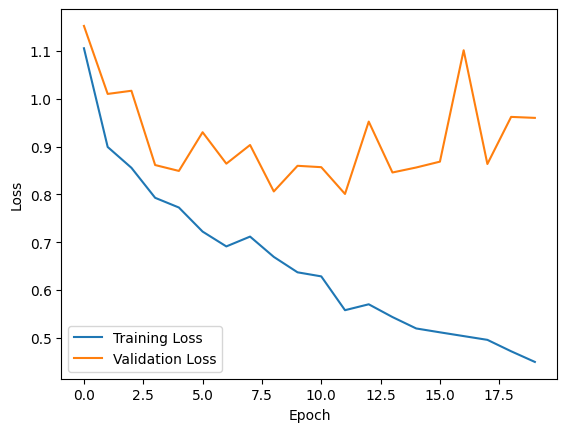

In [20]:
plt.plot(l_train_loss, label='Training Loss')
plt.plot(l_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

100%|██████████| 23/23 [02:00<00:00,  5.23s/it]


Accuracy: 0.7978
Precision (weighted): 0.8168
Recall (weighted): 0.7978
F1 Score (weighted): 0.8024

Classification Report:
              precision    recall  f1-score   support

           0      0.975     0.990     0.983       199
           1      0.474     0.600     0.529        30
           2      0.726     0.609     0.662        87
           3      0.267     0.471     0.340        17
           4      0.696     0.485     0.571        33

    accuracy                          0.798       366
   macro avg      0.627     0.631     0.617       366
weighted avg      0.817     0.798     0.802       366



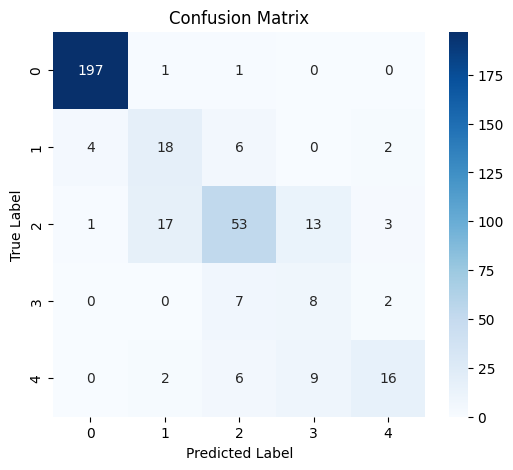

In [21]:
model.load_state_dict(torch.load("mobilenet_dr.pth"))
test_model(model, test_loader, criterion, device)